## Random Forest - Time series Forecast

In [12]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#get_ipython().run_line_magic('matplolib', 'inline')
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score, mean_squared_error

from sklearn import metrics
from timeit import default_timer as timer
from dateutil.parser import parse
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

from IPython.display import display, Markdown

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 800)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.5f}'.format

In [13]:
# Funções Auxiliares

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = pd.concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values


# split a univariate dataset into train/test sets
def train_test_split_func(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]


def random_forest_forecast(train, testX):
	# transform list into array
	train = np.asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = RandomForestRegressor(n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]        


def walk_forward_validation(data, n_test):
	predictions = list()
	
	# split dataset
	train, test = train_test_split_func(data, n_test)
	
	# seed history with training dataset
	history = [x for x in train]
	
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		
		# fit model on history and make a prediction
		yhat = random_forest_forecast(history, testX)
		
		# store forecast in list of predictions
		predictions.append(yhat)
		
		# add actual observation to history for the next loop
		history.append(test[i])
		
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, 1], predictions    


In [14]:
# load dataset
series = pd.read_csv('daily-total-female-births.csv', header=0, index_col=0)

display(series.head(10))

values = series.values


,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44
1959-01-06,29
1959-01-07,45
1959-01-08,43
1959-01-09,38


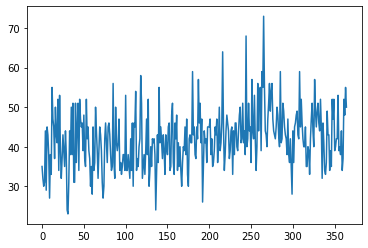

In [15]:
# plot dataset
plt.plot(values)
plt.show()

>expected=42.0, predicted=45.3
>expected=53.0, predicted=43.1
>expected=39.0, predicted=41.6
>expected=40.0, predicted=38.3
>expected=38.0, predicted=42.6
>expected=44.0, predicted=47.6
>expected=34.0, predicted=42.4
>expected=37.0, predicted=37.0
>expected=52.0, predicted=38.2
>expected=48.0, predicted=42.0
>expected=55.0, predicted=43.6
>expected=50.0, predicted=45.1
MAE: 5.855


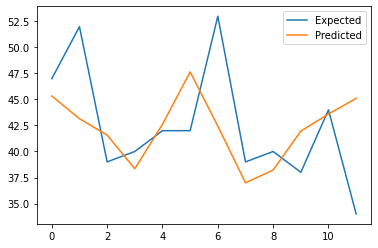

In [16]:
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)
# plot expected vs predicted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()